# Transverse vibrations of a nonlinear beam by Newmark-β time-stepping

In this notebook, we present an  implementation of the Newmark-β time-stepping technique, see also [Jérémy Bleyer's code](https://comet-fenics.readthedocs.io/en/latest/demo/elastodynamics/demo_elastodynamics.py.html). We consider a 2D hyperleastic beam of size `L × h` (2D, plane strain), fixed at both `x = 0` and `x = L` ends, and subjected to a volumetric transverse load $f$.

![shema](setup_flexion_clamp.png)

Introduction and elastodynamics equation
----------------------------------------

The elastodynamics equation writes (see slides on nonlinear elasticity) on the reference configuration $\Omega_0$:

$$\nabla \cdot P + f = \rho \ddot{u}$$

where $P$ is the first Piola-Kirchhoff stress tensor which can be obtained 
from the elastic potential $\Psi$ and the gradient of the transformation $F=\frac{\partial x}{\partial X}$ (with $x=X+u$) by

$$P = \frac{\partial \Psi}{\partial F}$$

The weak form is readily obtained by integrating by part the balance
equation using a test function $v\in V$ as in the linear case with $V$ being a suitable
function space that satisfies the displacement boundary conditions:

$$\int_{\Omega_0} \rho \ddot{u}\cdot v \, {\rm d} x + \int_{\Omega_0} P(u):\nabla v \, {\rm d} x =
\int_{\Omega_0} f \cdot v  \, {\rm d} x 
+ \int_{\partial\Omega_0} (P\cdot n) \cdot v \, {\rm d} s \quad \text{for all } v \in V
$$

The equation can be written as follows:

$$
\text{Find }u\in V\text{ such that } m(\ddot{u},v) + k_{NL}(u,v) = L(v) \quad \text{for all } v\in V
$$

where $m$ is the symmetric bilinear form associated with the mass matrix
and $k_{NL}$ the form associated with the stiffness which is only linear with $v$.

After introducing the finite element space interpolation, one obtains
the corresponding discretized evolution equation:

$$\text{Find }\{u\}\in\mathbb{R}^n\text{ such that } \{v\}^T[M]\{\ddot{u}\} + \{v\}^TF^{int}(\{u\}) = \{v\}^T\{F\} \quad \text{for all } \{v\}\in\mathbb{R}^n$$

where $F^{int}(\{u\})$ is the vector of internal force coming from the $k_{NL}(u,v)$ form and which is a nonlinear function of $u$.

Quite often in structural dynamics, structures do not oscillate
perfectly but lose energy through various dissipative mechanisms
(friction with air or supports, internal dissipation through plasticity,
damage, etc.). Dissipative terms can be introduced at the level of the
constitutive equation if these mechanisms are well known but quite often
it is not the case. Dissipation can then be modeled by adding an *ad
hoc* damping term depending on the structure velocity $\dot{u}$ to the
previous evolution equation:

$$\text{Find }u\in V\text{ such that } m(\ddot{u},v) + c(\dot{u},v) + k_{NL}(u,v) = L(v) \quad \text{for all } v\in V$$

The damping form will be considered here as bilinear and symmetric,
being therefore associated with a damping matrix $[C]$.

### Rayleigh damping

When little is known about the origin of damping in the structure, a
popular choice for the damping matrix, known as *Rayleigh damping*,
consists in using a linear combination of the mass and stiffness matrix
$[C] = \eta_M[M]+\eta_K[K]$ with two positive parameters $\eta_M,\eta_K$
which can be fitted against experimental measures for instance (usually
by measuring the damping ratio of two natural modes of vibration).
To simplify, the damping associated with the stiffness will be set to zero: $\eta_K=0$.

In [1]:
import dolfinx
from dolfinx import nls
import numpy as np
import matplotlib.pyplot as plt
import ufl
import time
import os
from mpi4py import MPI
import petsc4py.PETSc
import pyvista
import dolfinx.fem.petsc
import dolfinx.nls.petsc
import utils

[claire-Precision-5570:08315] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.claire-Precision-5570.1000/jf.0/2196832256/shared_mem_cuda_pool.claire-Precision-5570 could be created.
[claire-Precision-5570:08315] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


### Definition of the geometry and the mesh

In [2]:
# geometry and mesh 
L = 1.0 # total length
h = 0.1*L # thickness
d=h # an old typo: in this code we use both letters (d and h) to refer to the beam thickness, sorry.
e = d/4.0 # size of a cell


my_domain = dolfinx.mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=((0.0, -0.5*h), (L, 0.5*h)), n=(int(L/e), int(d/e)),
                            cell_type=dolfinx.mesh.CellType.triangle)

# Save the mesh in XDMF format
with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "output_dyn_impl/mesh.xdmf", "w") as file:
    file.write_mesh(my_domain)
    my_domain.topology.create_connectivity(1, 2)

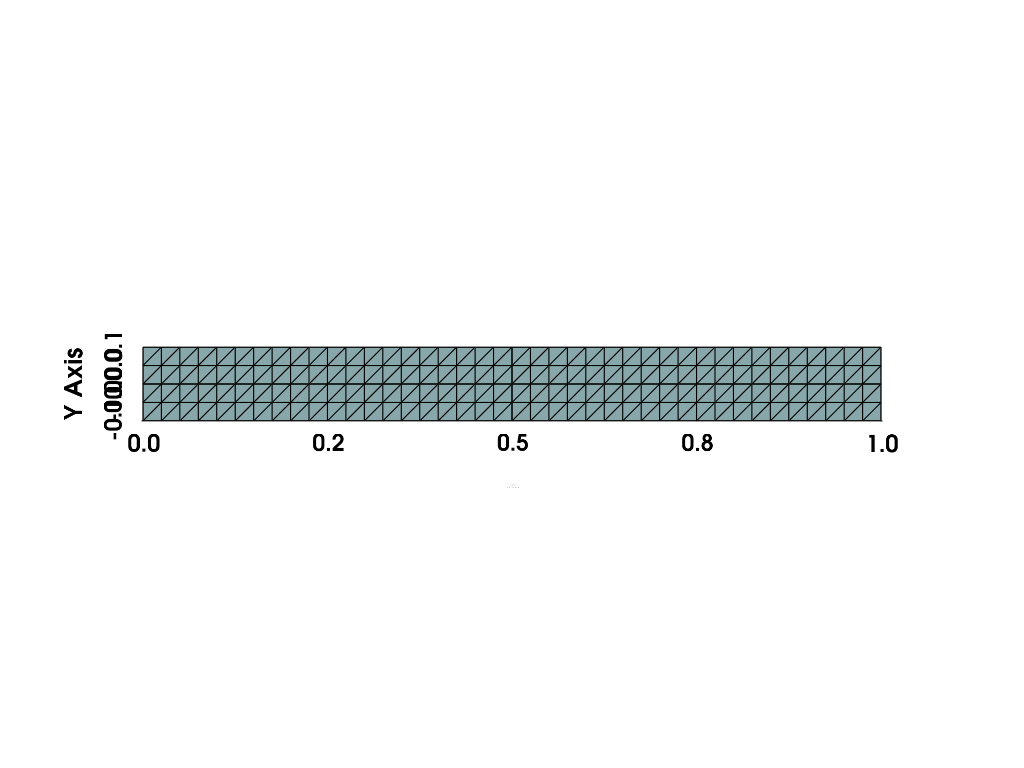

In [3]:
# Plot the mesh with pyvista
#pyvista.start_xvfb()
pyvista.set_jupyter_backend("static") # non-interactif, mais mieux
# pyvista.set_jupyter_backend("pythreejs") # interactif, mais pas super
topology, cells, geometry = dolfinx.plot.vtk_mesh(my_domain)
function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)
plotter = pyvista.Plotter()
plotter.add_mesh(function_grid, show_edges=True)
plotter.show_bounds(grid='front', location='outer', all_edges=False)
plotter.view_xy()
plotter.show()

In [4]:
# Define the different parts of the boundary
boundaries = [(1, lambda x: np.isclose(x[0], 0)),
              (2, lambda x: np.isclose(x[0], L)),
              (3, lambda x: np.isclose(x[1], -0.5*h)),
              (4, lambda x: np.isclose(x[1], 0.5*h))]
facet_indices, facet_markers = [], []
fdim = my_domain.topology.dim - 1
for (marker, locator) in boundaries:
    facets = dolfinx.mesh.locate_entities(my_domain, fdim, locator)
    facet_indices.append(facets) # here we put all the facets indices
    facet_markers.append(np.full_like(facets, marker)) # here we put all the facets 'labels' (1, 2, 3 or 4)
facet_indices = np.hstack(facet_indices).astype(np.int32) # concatenate everything in one big vector
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices) # sorting
facet_tag = dolfinx.mesh.meshtags(my_domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

In [5]:
dx = ufl.dx(domain=my_domain)

### Material parameters

In [6]:
# Material parameters
Y  = 1.
nu = 0.25
mu = Y/(2.*(1.+nu))
lambda_ = Y*nu/((1.+nu)*(1.-2.*nu))
rho = dolfinx.fem.Constant(my_domain,dolfinx.default_scalar_type(1.))

### Definition of the problem in nonlinear case (finite deformations)

In [7]:
V = dolfinx.fem.functionspace(my_domain, ("Lagrange", 1, (my_domain.geometry.dim, )))

In [9]:
boundary_clamped_dofs_left = dolfinx.fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.find(1)) # dofs on the left end of the bar
boundary_clamped_dofs_right = dolfinx.fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.find(2)) # dofs on the right end of the bar
#this is the boundary value of u(x,y) at the left border : it has to be zero (clamped)
u_D_left = np.array([0,0], dtype=dolfinx.default_scalar_type)
u_D_right = np.array([0,0], dtype=dolfinx.default_scalar_type)
bc_left = dolfinx.fem.dirichletbc(u_D_left, boundary_clamped_dofs_left, V)
bc_right = dolfinx.fem.dirichletbc(u_D_right, boundary_clamped_dofs_right, V)

In [10]:
# Nonlinear setup
I2 = ufl.Identity(2)

def energy_nonlinear(u):  
    F  = ufl.variable(I2 + ufl.grad(u))  
    CC = ufl.variable(F.T*F )                  
    Ic = ufl.variable(ufl.tr(CC))
    J  = ufl.variable(ufl.det(F))
    E  = ufl.variable(1/2*(CC-I2))
    # Stored strain energy density
    #psi = lambda_*ufl.tr(E)**2/2 + mu*ufl.inner(E,E) # Saint Venant–Kirchhoff
    psi = (mu/2)*(Ic - 2) - mu*ufl.ln(J) + (lambda_/2)*(ufl.ln(J))**2 # neo-Hookean
    return psi*dx

def stress_nonlinear(u):
    F = ufl.variable(I2 + ufl.grad(u))  
    CC = ufl.variable(F.T*F )                  
    Ic = ufl.variable(ufl.tr(CC))
    J  = ufl.variable(ufl.det(F))
    E  = ufl.variable(1/2*(CC-I2))
    # Stored strain energy density 
    #psi = lambda_*ufl.tr(E)**2/2 + mu*ufl.inner(E,E) # Saint Venant–Kirchhoff
    psi = (mu/2)*(Ic - 2) - mu*ufl.ln(J) + (lambda_/2)*(ufl.ln(J))**2 # neo-Hookean
    return ufl.diff(psi,F)

def strain_displacement_nonlinear(u):
    F = ufl.variable(I2 + ufl.grad(u))  
    CC = ufl.variable(F.T*F )                  
    Ic = ufl.variable(ufl.tr(CC))
    J  = ufl.variable(ufl.det(F))
    E  = ufl.variable(1/2*(CC-I2))
    return E

def stiffness_nonlinear(u, v):
    return ufl.inner(stress_nonlinear(u),ufl.grad(v))*dx

In [11]:
eta_m = dolfinx.fem.Constant(my_domain,dolfinx.default_scalar_type(0.01))
# not used eta_k = dolfinx.fem.Constant(my_domain,dolfinx.default_scalar_type(0.))

f = dolfinx.fem.Constant(my_domain, dolfinx.default_scalar_type((0, 0)))

def mass(u, v):
    return rho*ufl.inner(u, v)*dx

def damping(u, v): 
    return eta_m*mass(u, v) #+ eta_k*stiffness_linear(u, v)

def p_ext(u):
    return ufl.dot(f,u)*dx # volumetric load (e.g. weight)

In [12]:
u_bar = ufl.TestFunction(V)

In [13]:
u_sol = dolfinx.fem.Function(V)# displacement of the solution
v_sol = dolfinx.fem.Function(V)# velocity of the solution
a_sol = dolfinx.fem.Function(V)# acceleration of the solution

# `Questions start here`

#### Replace the XXX with appropriate fenicsx code

## Implicit time-stepping scheme

### Time discretization using the Newmark-$\beta$ method

We now introduce a time discretization of the interval study $[0;T]$ in
$N+1$ time increments $t_0=0,t_1,\ldots,t_N,t_{N+1}=T$ with
$\Delta t=T/N$ denoting the time step (supposed constant). The
resolution will make use of the Newmark-$\beta$ method in
structural dynamics. As an implicit method, it is unconditionally stable
for a proper choice of coefficients so that quite large time steps can
be used. It also allows for high frequency dissipation and offers a
second-order accuracy, i.e. in $O(\Delta t^2)$.

The method consists in solving the dynamic evolution equation at
intermediate time between $t_n$ and $t_{n+1}$ as follows:

$$[Eq1] \quad [M]\{\ddot{u}_{n+1}\} + [C]\{\dot{u}_{n+1}\}+\{F^{int}(u_{n+1}) \}= \{F(t_{n+1})\}$$

Note that the first two terms involve the mass matrix [M] and the damping matrix [C] and are linear relative to the vector
${u}_{n+1}$ or its time derivative.
On the contrary, the third term $\{F^{int}(u_{n+1})\}$ is a non linear function of $\{{u}_{n+1}\}$ and gives
the internal forces resulting from the non linear behavior of the material or from large strains.

*The following approximations for the displacement and velocity
at $t_{n+1}$ are used:

$$ [Eq2] \quad 
\{u_{n+1}\} = \{u_{n}\}+\Delta t \{\dot{u}_{n}\} + \dfrac{\Delta t^2}{2}\left((1-2\beta)\{\ddot{u}_{n}\}+2\beta\{\ddot{u}_{n+1}\}\right)
$$
that can also be written as
$$ 
[Eq3]\quad  \{u_{n+1}\} =  \{ \hat{u}_n\} + \Delta t^2 \, \beta \, \{\ddot{u}_{n+1}\}
$$
with
$$ \quad 
\{ \hat{u}_n\}  = \{u_{n}\}+\Delta t \{\dot{u}_{n}\} + \dfrac{\Delta t^2}{2}(1-2\beta)\{\ddot{u}_{n}\}
$$
and for the velocity
$$
[Eq4]\quad  \{\dot{u}_{n+1}\} =  \{ \hat{\dot{u}}_n\} + \Delta t \, \gamma \, \{\ddot{u}_{n+1}\}
$$
with
$$  
\{ \hat{\dot{u}}_n\} = \{\dot{u}_{n}\} + \Delta t(1-\gamma)\{\ddot{u}_{n}\}
$$

### Time-discretization parameters

Parameters of the Newmark-β method.
A popular choice of parameters which ensures unconditional stability, optimal dissipation and second-order accuracy is:
$$\gamma=\frac{1}{2},\quad \beta=\frac{1}{4}$$

In [ ]:
gamma = 1./2.
beta = 1./4.

At time step $n$, when $u_n$, $\dot{u}_n$, and $\ddot{u}_n$ are known, [Eq1-2-3-4] can be used to write an equation for $\ddot{u}_{n+1}$ 

$$ [Eq5] \quad 
[M] \, \{\ddot{u}_{n+1}\} + \gamma\Delta t\, [C] \{\ddot{u}_{n+1}\}  + F^{int}(\{ \hat{u}_n\} + \Delta t^2 \, \beta \, \{\ddot{u}_{n+1}\})= \{F(t_{n+1})\}  - [C] \, \{\hat{\dot{u}}_n\}
$$
The left-hand side defines a non linear operator of the acceleration $\ddot{u}_{n+1}$ that can be written as
\begin{equation*}
[Eq6]\ \ \
\{A\}( \{\ddot{u}_{n+1}\}) = [M] \, \{\ddot{u}_{n+1}\} + \gamma\Delta t\, [C] \{\ddot{u}_{n+1}\}  + F^{int}(\{ \hat{u}_n\} + \Delta t^2 \, \beta \, \{\ddot{u}_{n+1}\})
\end{equation*}
where the non linearity comes from the interior forces.
Then, the problem consists in solving the non linear equation
\begin{equation*}
[Eq7]\ \ \
\{A\}( \{\ddot{u}_{n+1}\}) = \{F(t_{n+1})\}  - [C] \, \{\hat{\dot{u}}_n\}
\end{equation*}

Then, once [Eq5] is solved and we know $\{\ddot{u}_{n+1}\}$, we update the values of $\{u_n\}$ and $\{\dot{u}_n\}$ using [Eq3] and [Eq4]:
$$ 
[Eq8]\quad  \{u_{n+1}\} =  \{ \hat{u}_n\} + \Delta t^2 \, \beta \, \{\ddot{u}_{n+1}\}
$$
and
$$
[Eq9]\quad  \{\dot{u}_{n+1}\} =  \{ \hat{\dot{u}}_n\} + \Delta t \, \gamma \, \{\ddot{u}_{n+1}\}
$$

In [ ]:
dt = dolfinx.fem.Constant(my_domain,dolfinx.default_scalar_type(0.0))
# Define the nonlinear operator A(u, u_bar) described in relation [Eq6] for a test function u_bar
# with Eq.6
def A(u, u_bar):
    return mass(u, u_bar) + XXX + XXX

We define the residual as the left-hand side of [Eq7] minus its right hand-side and the nonlinear problem associated to this residual.

In [ ]:
residual = A(a_sol, XXX) - XXX + XXX # from Eq.7
problem = dolfinx.fem.petsc.NonlinearProblem(residual, a_sol, bcs=[bc_left, bc_right])
solverNL = nls.petsc.NewtonSolver(my_domain.comm, problem)

# Set linear solver options
ksp = solverNL.krylov_solver
opts = petsc4py.PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()
# Set Newton solver options
solverNL.atol = 1e-8
solverNL.rtol = 1e-8
solverNL.max_it = 1000
solverNL.convergence_criterion = "incremental"

## Parameters of the simulation

### Material, loading and time-discretization parameters

A time-dependent transverse volumetric force $f$ is applied as follows
\begin{equation}
f = \begin{cases}
\displaystyle\frac{t}{t_{\mathrm{c}}} f_{\mathrm{max}} & t \leq t_{\mathrm{c}}\\[.2em]
0 & t > t_{\mathrm{c}}
\end{cases}
\end{equation}
where $t_{\mathrm{c}}$ is a “cut-off” time. Note that depending on the direction of the applied traction, we will need to select different values for `t_c` and `f_max`.

In [ ]:
# Damping parameters
# The damping matrix C is defined as C = eta_m * M
eta_m.value = 0.01 # for which value do you obtain a critically damped response?
# Loading
t_end = 100. # end time of the simulation
num_steps  = 300 # total number of steps for the entire simulation
dt.value = t_end/num_steps # Is there an upper limit for the time step (can you go up to dt=1?)
print('time step = ',dt.value)
t_cutoff = 35 # time duration for which we apply self-weight (this t_c).
#              How small can this time be if you want to reach the static state?
#              For example, with tc=20 are you loading up to statics sate?
f_max = 0.05 # Max applied weight. Example: f_max=0.05 yields a static vertical displacement of 0.1. 
#              How does the static vertical displacement vary with f_max?

def load_eval(t):
    if t <= t_cutoff:
        return f_max*t/t_cutoff
    else:
        return 0

In [ ]:
# A theoretical formula to have an approximation of the static state
gamma_adim=12*f_max*L**3/Y/d**2
eta=1/12.0*(d/L)**2
print('Gamma adim = ',gamma_adim)
print('1/eta = ',1/eta)
tmp = (gamma_adim/eta**0.5)**0.5
Happrox = 84.33 * gamma_adim * (0.114 * tmp - 4 * np.tanh(0.0285 * tmp)) / tmp**3
print('Static vertical displacement of mid point  = ',Happrox)

In [ ]:
# the loop for time integration is here
time_solve = 0.

u_sol.x.array[:] = 0.0
v_sol.x.array[:] = 0.0
a_sol.x.array[:] = 0.0
   
times = dt.value*np.arange(num_steps+1, dtype=np.float64)
displ_tip = np.zeros_like(times)
    
with dolfinx.io.XDMFFile(my_domain.comm, "output_dyn_impl/time_steps_u.xdmf", "w") as file:
    file.write_mesh(my_domain)

for n in range(num_steps):
    f.value[1] = load_eval((n+1)*dt.value) # update transverse loading
    if (n%100 == 0):
        print(n,' / ', num_steps)
    # 1. Predictor step
    # u_t = u + dt * v_t +  a_t * (1 - 2*beta) * dt**2 / 2 
    u_XXX.vector.axpy(XXX, XXX.vector)
    u_XXX.vector.axpy(XXX, XXX.vector)
    # v_t = v + a_t * (1 - gamma) * dt 
    v_XXX.vector.axpy(XXX, XXX.vector)

    # 2. Update acceleration
    # Solve for acceleration, Eq7
    t1 = time.perf_counter()
    num_its, converged = solverNL.solve(a_sol)
    t2 = time.perf_counter()
    time_solve += t2 - t1
    
    # 3. Corrector step
    # u_t = u_t + a_t * beta * dt**2
    # v_t = v_t + a_t * gamma * dt 
    u_XXX.vector.axpy(XXX, XXX.vector)
    v_XXX.vector.axpy(XXX, XXX.vector)
    
    # Postprocessing 
    displ_tip[n+1]=utils.evaluate_at_points(np.array([[L/2.],[0.0],[0.0]]), u_sol)[0,1]

    if (n%10 == 0):
        dummy_line=1
        file.write_function(u_sol, (n+1)*dt.value) # comment this line if you dont want the xdmf export

# Close xmdf file
file.close()
print('time spent in the NL solver: ',time_solve)
print('time for files saving:',XXX)
print('Total time: ',XXX)

In [ ]:
plt.figure()
plt.plot(times, displ_tip, 'k.-')
plt.plot(times,  Happrox*np.ones_like(times), '--g') # what is this limit?
plt.plot(times, -Happrox*np.ones_like(times), '--g') # what is this limit?
plt.grid()
plt.xlabel("Time")
plt.ylabel("Tip displacement")
#plt.savefig("tip_displacement.png")

## Flexural and extensional vibration periods

In [ ]:
# In the 1D linear case (using beam theory - RDM):
I = h*h*h/12
a0 = 22.37
f0_beam = a0/2/np.pi*np.sqrt(Y/rho.value)/L/L*np.sqrt(I/h)
print('Period for 1st mode of transverse vibrations of an elastic clamped-clamped beam = ',1/f0_beam)

In [ ]:
# In the 1D linear case (using beam theory - RDM):
f0_bar = np.sqrt(Y/rho.value)/L/2
print('Period for 1st mode of longitudinal vibrations of an elastic clamped-clamped beam = ',1/f0_bar)